##### Content analysis, sentiment analysis, and labeling

In [63]:
import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np

pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


In [64]:
df = pd.read_excel('../data/setn')

##### Drop null, empty, and duplicates

In [65]:
df.dropna(subset=['text'], inplace=True) #remove nan value
df.drop_duplicates(subset=['text'], inplace=True) #remove nan duplicate value
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=1, how='all').loc[:, df.notna().any()]


In [66]:
df.head()

,text,name,created_at,gender,ethnic
0,"1/3 The Doha Agreement will remain not only in the heart of our history and part of the history of the aggressors, but also as a document and solution to end...",AnasHaqqani313,2023-03-01 01:45:29,male,pashtun
1,2/2 He who is silent appears to be a wise man. He who speaks seems to be a child without wisdom.,AnasHaqqani313,2023-02-08 16:22:27,male,pashtun
2,"1/2 The fact that today everyone seems poor and deprived, tomorrow his name will appear in the pages of history.",AnasHaqqani313,2023-02-08 16:22:26,male,pashtun
3,"RT This illiterate Afghani mother who was left behind from the university seats, and her death is the mirage called (the dream of graduation). She missed being a teacher, or an engineer; but you…",AnasHaqqani313,2023-01-12 16:44:08,male,pashtun
4,"Pir Muhammad is truly a caravan, because he is not one; It is a collection of ideas, thoughts, emotions, feelings and paintings. Some people...",AnasHaqqani313,2022-11-22 15:49:22,male,pashtun


##### Clean data

In [67]:
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


In [68]:
df.head()

,text,name,created_at,gender,ethnic
0,the doha agreement will remain not only in the heart of our history and part of the history of the aggressors but also as a document and solution to end,AnasHaqqani313,2023-03-01 01:45:29,male,pashtun
1,he who is silent appears to be a wise man he who speaks seems to be a child without wisdom,AnasHaqqani313,2023-02-08 16:22:27,male,pashtun
2,the fact that today everyone seems poor and deprived tomorrow his name will appear in the pages of history,AnasHaqqani313,2023-02-08 16:22:26,male,pashtun
3,this illiterate afghani mother who was left behind from the university seats and her death is the mirage called the dream of graduation she missed being a teacher or an engineer but you,AnasHaqqani313,2023-01-12 16:44:08,male,pashtun
4,pir muhammad is truly a caravan because he is not one it is a collection of ideas thoughts emotions feelings and paintings some people,AnasHaqqani313,2022-11-22 15:49:22,male,pashtun


In [69]:
import numpy as np
df = df[df['text'].str.len() >=30]

In [70]:
df.head()

,text,name,created_at,gender,ethnic
0,the doha agreement will remain not only in the heart of our history and part of the history of the aggressors but also as a document and solution to end,AnasHaqqani313,2023-03-01 01:45:29,male,pashtun
1,he who is silent appears to be a wise man he who speaks seems to be a child without wisdom,AnasHaqqani313,2023-02-08 16:22:27,male,pashtun
2,the fact that today everyone seems poor and deprived tomorrow his name will appear in the pages of history,AnasHaqqani313,2023-02-08 16:22:26,male,pashtun
3,this illiterate afghani mother who was left behind from the university seats and her death is the mirage called the dream of graduation she missed being a teacher or an engineer but you,AnasHaqqani313,2023-01-12 16:44:08,male,pashtun
4,pir muhammad is truly a caravan because he is not one it is a collection of ideas thoughts emotions feelings and paintings some people,AnasHaqqani313,2022-11-22 15:49:22,male,pashtun


In [71]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


In [20]:
df.head()

,text,name,created_at,gender,ethnic
0,look at womens lobbies the lives of defenseless afghan women the rape of the taliban governor in sarpul on the mother and yearold daughter,ZarminaParyani,2023-03-09 06:53:36,female,tajik
2,has a wave without bounds the eyes of sepahan girls smell of tahmina samangani girls mothers of the khurshid region greetings to the zeal of shahnameh,ZarminaParyani,2023-03-06 18:27:36,female,tajik
4,being a woman and becoming young in an illiterate society,ZarminaParyani,2023-03-05 09:13:16,female,tajik
5,curse the women inside afghanistan with hijab and without makeup for the crime of not wearing a black niqab in the government of taleb shala,ZarminaParyani,2023-03-04 19:35:30,female,tajik
6,qanel terrorists criminals we will not be forgotten what did you do to us the insulting behavior of intellectuals is worse than this terrorist crime,ZarminaParyani,2023-03-02 06:27:30,female,tajik


In [72]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


In [73]:
df.head()

,text,name,created_at,gender,ethnic
0,the doha agreement will remain not only in the heart of our history and part of the history of the aggressors but also as a document and solution to end,AnasHaqqani313,2023-03-01 01:45:29,male,pashtun
1,he who is silent appears to be a wise man he who speaks seems to be a child without wisdom,AnasHaqqani313,2023-02-08 16:22:27,male,pashtun
2,the fact that today everyone seems poor and deprived tomorrow his name will appear in the pages of history,AnasHaqqani313,2023-02-08 16:22:26,male,pashtun
3,this illiterate afghani mother who was left behind from the university seats and her death is the mirage called the dream of graduation she missed being a teacher or an engineer but you,AnasHaqqani313,2023-01-12 16:44:08,male,pashtun
4,pir muhammad is truly a caravan because he is not one it is a collection of ideas thoughts emotions feelings and paintings some people,AnasHaqqani313,2022-11-22 15:49:22,male,pashtun


##### Remove stopwords

In [74]:
from nltk.corpus import stopwords
def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df
df = remove_stopwords(df)

In [75]:
df.head()

,text,name,created_at,gender,ethnic
0,doha agreement remain heart history part history aggressors also document solution end,AnasHaqqani313,2023-03-01 01:45:29,male,pashtun
1,silent appears wise man speaks seems child without wisdom,AnasHaqqani313,2023-02-08 16:22:27,male,pashtun
2,fact today everyone seems poor deprived tomorrow name appear pages history,AnasHaqqani313,2023-02-08 16:22:26,male,pashtun
3,illiterate afghani mother left behind university seats death mirage called dream graduation missed teacher engineer,AnasHaqqani313,2023-01-12 16:44:08,male,pashtun
4,pir muhammad truly caravan one collection ideas thoughts emotions feelings paintings people,AnasHaqqani313,2022-11-22 15:49:22,male,pashtun


In [76]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

In [77]:
df.shape

(51, 5)

##### Delete tweets >=2020

In [78]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year < 2020].index, inplace=True)

In [79]:
df.head()

,text,name,created_at,gender,ethnic
0,doha agreement remain heart history part history aggressors also document solution end,AnasHaqqani313,2023-03-01,male,pashtun
1,silent appears wise man speaks seems child without wisdom,AnasHaqqani313,2023-02-08,male,pashtun
2,fact today everyone seems poor deprived tomorrow name appear pages history,AnasHaqqani313,2023-02-08,male,pashtun
3,illiterate afghani mother left behind university seats death mirage called dream graduation missed teacher engineer,AnasHaqqani313,2023-01-12,male,pashtun
4,pir muhammad truly caravan one collection ideas thoughts emotions feelings paintings people,AnasHaqqani313,2022-11-22,male,pashtun


In [80]:
len(df['name'].unique())

1

In [81]:
df.head()

,text,name,created_at,gender,ethnic
0,doha agreement remain heart history part history aggressors also document solution end,AnasHaqqani313,2023-03-01,male,pashtun
1,silent appears wise man speaks seems child without wisdom,AnasHaqqani313,2023-02-08,male,pashtun
2,fact today everyone seems poor deprived tomorrow name appear pages history,AnasHaqqani313,2023-02-08,male,pashtun
3,illiterate afghani mother left behind university seats death mirage called dream graduation missed teacher engineer,AnasHaqqani313,2023-01-12,male,pashtun
4,pir muhammad truly caravan one collection ideas thoughts emotions feelings paintings people,AnasHaqqani313,2022-11-22,male,pashtun


In [82]:
df.shape

(51, 5)

##### Labeling Processing

In [83]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str)

In [84]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment analysis

In [85]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

In [88]:
positive_df=df[df['sentiment'] == 'positive']
positive_df[['text','name', 'gender', 'label', 'sentiment', 'sentiment_score']].sample(3)

,text,name,gender,label,sentiment,sentiment_score
24,today met dr nakamuras close friend colleague nishitani famikozu interested activities afghanistan,AnasHaqqani313,male,0,positive,0.250000
18,² love kills conscience eyes mind blinded love city heart execution order everyone intention love,AnasHaqqani313,male,0,positive,0.500000
6,seemed small characteristic perfect faith struggle physically deleting enemy,AnasHaqqani313,male,0,positive,0.170833


##### Calculate positive tweets and percentage for women, single user


In [89]:
# women_positive_count = df[(df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
# women_total_count = df[df['gender'] == 'female'].shape[0]
# women_positive_percentage = (women_positive_count / women_total_count) * 100
# # Print the results
# print("Positive tweets from women:", women_positive_count, "(", women_positive_percentage, "%)")

In [90]:
women_positive_count = df[(df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'female'].shape[0]

if women_total_count == 0:
    women_positive_percentage = 0  # Assign a default value or handle it accordingly
else:
    women_positive_percentage = (women_positive_count / women_total_count) * 100

# Print the results
print("Positive tweets from women:", women_positive_count, "(", women_positive_percentage, "%)")


Positive tweets from women: 0 ( 0 %)


In [91]:
keywords = ['women education']
# # Calculate positive tweets and percentages for each keyword
# for keyword in keywords:
#     keyword_positive_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
#     keyword_total_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'female')].shape[0]
#     keyword_positive_percentage = (keyword_positive_count / keyword_total_count) * 100
#     # Print the results for each keyword
#     print(f"Positive tweets related to '{keyword}' from women:", keyword_positive_count, "(", keyword_positive_percentage, "%)")


In [92]:
for keyword in keywords:
    keyword_positive_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
    keyword_total_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'female')].shape[0]
    
    if keyword_total_count == 0:
        keyword_positive_percentage = 0  # Assign a default value or handle it accordingly
    else:
        keyword_positive_percentage = (keyword_positive_count / keyword_total_count) * 100
    
    print(f"Positive tweets related to '{keyword}' from women:", keyword_positive_count, "(", keyword_positive_percentage, "%)")


Positive tweets related to 'women education' from women: 0 ( 0 %)


In [93]:
# for keyword in keywords:
#     keyword_positive_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
#     keyword_total_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'male')].shape[0]
#     keyword_positive_percentage = (keyword_positive_count / keyword_total_count) * 100
#     # Print the results for each keyword
#     print(f"Positive tweets related to '{keyword}' from men:", keyword_positive_count, "(", keyword_positive_percentage, "%)")

In [94]:
for keyword in keywords:
    keyword_positive_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
    keyword_total_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'male')].shape[0]
    
    if keyword_total_count == 0:
        keyword_positive_percentage = 0  # Assign a default value or handle it accordingly
    else:
        keyword_positive_percentage = (keyword_positive_count / keyword_total_count) * 100
    
    print(f"Positive tweets related to '{keyword}' from men:", keyword_positive_count, "(", keyword_positive_percentage, "%)")


Positive tweets related to 'women education' from men: 0 ( 0 %)


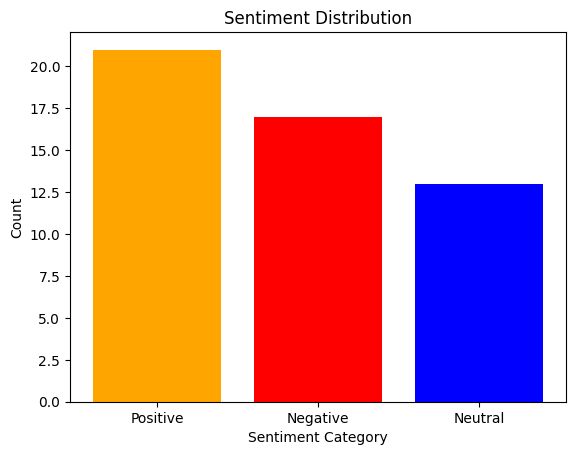

In [95]:
import matplotlib.pyplot as plt
# Bar chart
sentiment_categories = ['Positive', 'Negative', 'Neutral']
counts = df['sentiment'].value_counts()
colors = ['orange', 'red', 'blue']
plt.bar(sentiment_categories, counts, color=colors)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

##### Pie chart


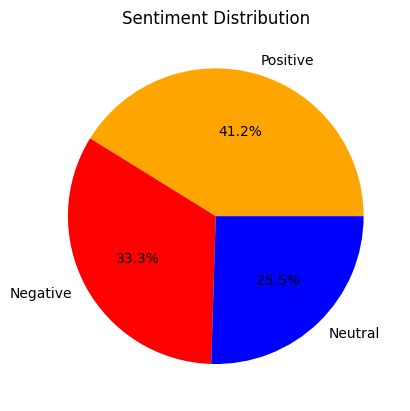

In [96]:
sentiment_categories = ['Positive', 'Negative', 'Neutral']
counts = df['sentiment'].value_counts()
colors = ['orange', 'red', 'blue']
plt.pie(counts, labels=sentiment_categories, colors=colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

##### Data set summary

In [97]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)


Sentiment Counts:
 sentiment
positive    21
negative    17
neutral     13
Name: count, dtype: int64
Total Counts: 38


In [98]:
positive_df = df[df['sentiment'] == 'positive']
positive_df[['text','sentiment','sentiment_score','gender','label']].sample(5)

,text,sentiment,sentiment_score,gender,label
1,silent appears wise man speaks seems child without wisdom,positive,0.3500,male,0
8,strange picture mirror sky noise happiness loud appeared freely shaheen sahib hoping poems,positive,0.2875,male,0
35,dont vindictive use patience tolerance protect national facilities real estate documents vice president haqqani islamic emirate,positive,0.2000,male,0
51,morale service alive goal revival action plans failures,positive,0.1000,male,0
26,karwan sahib great historical entity afghanistan,positive,0.4000,male,0


##### Content Analysis

In [99]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  10


##### Code Schema

In [100]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

# Check the first 10 rows of the DataFrame
df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

,text,sentiment,sentiment_score,gender,label,codes
16,today visited kabul university afghanistans largest historic center knowledge visiting un,negative,-0.050000,male,1,"[education, university]"
49,attack kabul university work enemies light islam peace knowledge attack painful sad kabul,negative,-0.266667,male,1,"[education, university]"
46,attack kabul university work enemies islampeace light knowledge attack,positive,0.400000,male,1,"[education, university]"
44,country needs rebuilding destruction occupation fact construction schools acade,neutral,0.000000,male,1,[school]
48,attack kabul university work enemies islam peace light science act attack painful sad,negative,-0.266667,male,1,[university]


##### Visualization

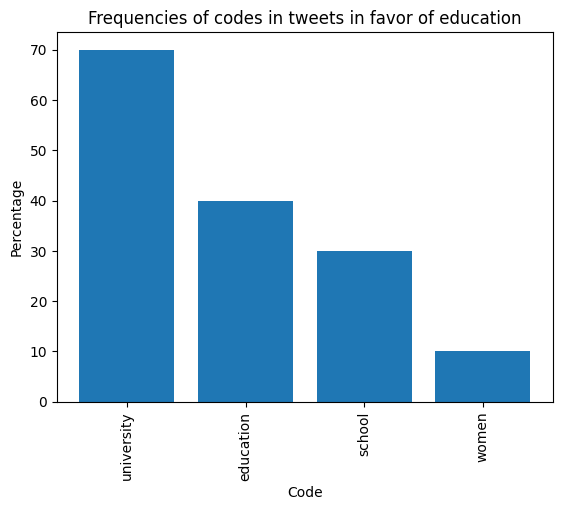

In [101]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()



##### Tone of every keywords

In [102]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
Series([], Name: text, dtype: int64)
Sentiment analysis of tweets containing the keyword 'education':
sentiment
neutral    1
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
neutral     1
positive    1
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    4
neutral     1
positive    2
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
neutral    1
Name: text, dtype: int64


In [103]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
Series([], Name: text, dtype: object)


##### Average Sentiment

In [104]:
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")

Average sentiment score for all tweets: 0


##### Sentiment Category

In [105]:
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)               0.000000
(education, university)    0.027778
(school,)                  0.000000
(school, university)       0.050000
(university,)             -0.133333
Name: text, dtype: float64

##### Comparison of Sentiment

In [106]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

Comparison of Sentiment:
T-statistic: 0.9576666592144586
P-value: 0.3428387783290945


##### Chi-square test of independence

In [107]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 0.0
P-value: 1.0


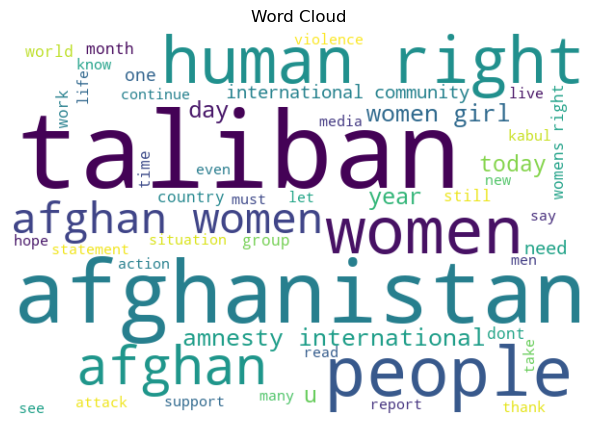

In [230]:
# from wordcloud import WordCloud
# text_data = " ".join(df['text'].tolist())
# wordcloud = WordCloud(width=600, height=400, max_words=50, background_color='white').generate(text_data)
# # Plot the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud')
# plt.show()


##### Save excel

In [108]:
df.to_excel('../data_processed/indivitual/anas_haqani_official.xlsx', index=False)

##### =================== Multi user ======================


In [3]:
df = pd.read_excel('../data_processed/indivitual/new_education.xlsx')

In [4]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str)

In [5]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl','ban']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

In [6]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Calculate positive tweets and percentage for women and men


In [7]:
women_positive_count = df[(df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'female'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Calculate positive tweets and percentage for men
men_positive_count = df[(df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
men_total_count = df[df['gender'] == 'male'].shape[0]
men_positive_percentage = (men_positive_count / men_total_count) * 100
# -
print("Positive tweets from women:", women_positive_count, "(", women_positive_percentage, "%)")
print("Positive tweets from men:", men_positive_count, "(", men_positive_percentage, "%)")

Positive tweets from women: 10301 ( 38.93340388540328 %)
Positive tweets from men: 1355 ( 42.133084577114424 %)


##### Calculate positive tweets and percentages for each keyword


In [8]:
keywords = ['women education']
for keyword in keywords:
    keyword_positive_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
    keyword_total_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'female')].shape[0]
    keyword_positive_percentage = (keyword_positive_count / keyword_total_count) * 100
    # -
    print(f"Positive tweets related to '{keyword}' from women:", keyword_positive_count, "(", keyword_positive_percentage, "%)")


Positive tweets related to 'women education' from women: 25 ( 49.01960784313725 %)


In [9]:
# Define the list of keywords related to women education
keywords = ['women education']

# Calculate positive tweets and percentages for each keyword
for keyword in keywords:
    keyword_positive_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
    keyword_total_count = df[(df['text'].str.contains(keyword, case=False)) & (df['gender'] == 'male')].shape[0]
    keyword_positive_percentage = (keyword_positive_count / keyword_total_count) * 100

    # Print the results for each keyword
    print(f"Positive tweets related to '{keyword}' from men:", keyword_positive_count, "(", keyword_positive_percentage, "%)")


Positive tweets related to 'women education' from men: 2 ( 66.66666666666666 %)


##### Get tweets of women education

In [10]:
keyword = 'women education'
keyword_tweets = df[df['text'].str.contains(keyword, case=False)]
filtered_df = keyword_tweets[['text', 'gender']]
filtered_df.sample(5)


,text,gender
9340,taliban afghanistan country prohibit women education,female
7955,taliban ban afghan women education basic human rights least world could ban taliban fro,female
11968,even taliban decides lift bans women education work make life difficult environment oppressive means writes kazim ehsan,female
10434,excuse taliban make right banning women education waiting proper time safe exactly thing happened thousands girls wanted go university,female
12039,taliban arrested afghan professor ismailmashal backed women education clip episode earlier week lauryn oates says country drained human capital let afghan girls learn,female


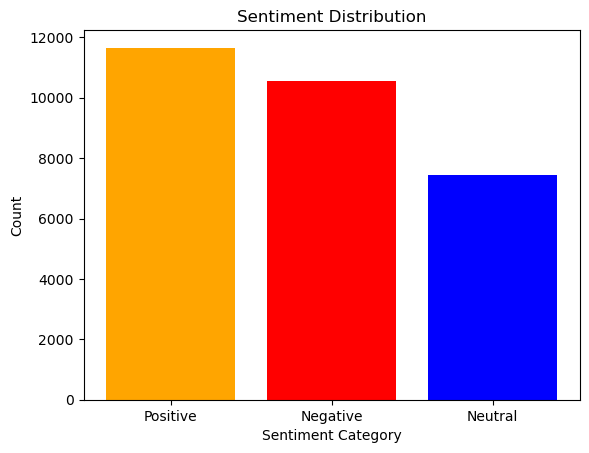

In [11]:
import matplotlib.pyplot as plt
# Bar chart
sentiment_categories = ['Positive', 'Negative', 'Neutral']
counts = df['sentiment'].value_counts()
colors = ['orange', 'red', 'blue']
plt.bar(sentiment_categories, counts, color=colors)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()



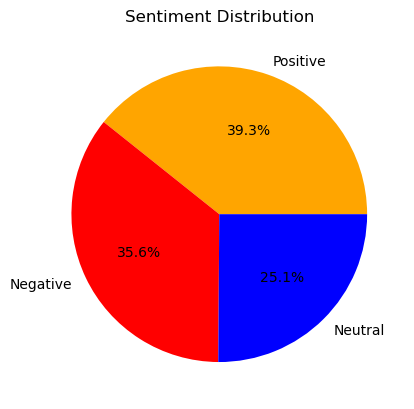

In [12]:
# Pie chart
sentiment_categories = ['Positive', 'Negative', 'Neutral']
counts = df['sentiment'].value_counts()
colors = ['orange', 'red', 'blue']
plt.pie(counts, labels=sentiment_categories, colors=colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

##### Data set summary

In [13]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)


Sentiment Counts:
 sentiment
positive    11656
neutral     10567
negative     7451
Name: count, dtype: int64
Total Counts: 19107


In [14]:
positive_df = df[df['sentiment'] == 'positive']
positive_df[['text','sentiment','sentiment_score','gender','label']].sample(5)

,text,sentiment,sentiment_score,gender,label
28590,marketing army suicide bombers didnt win claim peace taliban know terror,positive,0.800000,female,0
28708,mandol nuristan becomes first district liberated taliban freeafghanistan,positive,0.250000,female,0
26558,still afghanistan human rights violations rife womens rights activists faced particular intimidation violence still risk stories read report,positive,0.083333,female,1
9053,yaqubyasna national resistance front passed tough difficult test days able win unequal war taliban attackers,positive,0.102778,male,0
5074,congratulations much deserved defender year award principled relentless defender human rights everywhere never hesitated speak truth power unlike many project driven advocates salute respect,positive,0.233333,female,0


##### Content Analysis

In [15]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  10855


##### Code Schema

In [16]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

# Check the first 10 rows of the DataFrame
df_edu[['text','sentiment','sentiment_score','gender','label']].sample(5)

,text,sentiment,sentiment_score,gender,label
19946,current year buildings built schools dara noor district iqra program create local classes girls girls given modern religious education,positive,0.05,male,1
4574,taliban made men unwilling accomplices oppression women hijab edict powerful example men courageously standing solidarity women protesting taliban kind leadership afghanistan needs,positive,0.45,female,1
22985,much gratitude moderating panel amplified voices afghanwomen humanrights,positive,0.20,female,1
13457,feel courage smiles voices today women afghanistan,neutral,0.00,female,1
28033,afghanistan already facing humanitarian crisis barring afghan women participation public life deprive women human rights speakupforafghanwomen sign petition daysofactivism,neutral,0.00,female,1


##### Visualize

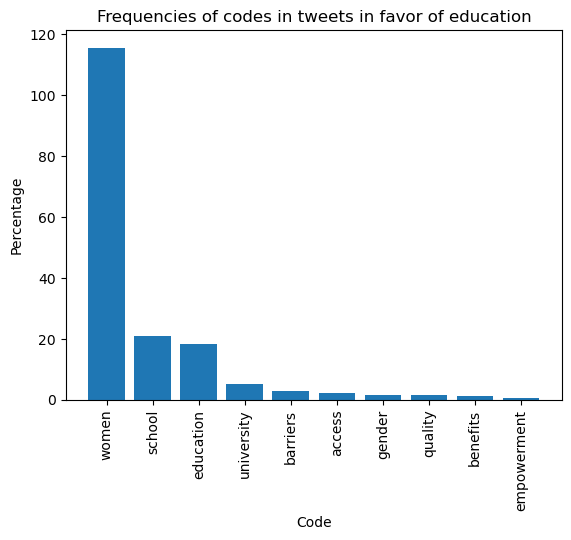

In [17]:
import matplotlib.pyplot as plt

# Explode the codes column to create a new row for each code in each tweet
df_codes = df_edu.explode('codes')

# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100

# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)

plt.ylabel('Percentage')
plt.show()



In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative    1792
neutral     2847
positive    3258
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative    464
neutral     380
positive    958
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    606
neutral     555
positive    647
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    105
neutral     172
positive    190
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative    1127
neutral     1285
positive    1573
Name: text, dtype: int64


In [19]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    12
neutral     15
positive    27
Name: text, dtype: int64


In [20]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    12 (22.2%)
neutral     15 (27.8%)
positive    27 (50.0%)
Name: text, dtype: object


##### Average sentiment

In [21]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")

Average sentiment score for all tweets: 0.07320987654320987


##### Sentiment Category

In [22]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)                      0.065619
(education, access)               0.005051
(education, access, benefits)    -0.600000
(education, education)            0.067002
(education, education, access)    0.250000
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [23]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment between Women and Men:")
print("T-statistic:", t_stat)
print("P-value:", p_value)
##### Calculate the sentiment scores for all tweets

Comparison of Sentiment between Women and Men:
T-statistic: 30.960331603059124
P-value: 3.6645105462286995e-207


#### Calculate the sentiment scores for tweets containing each keyword


In [24]:
#### Calculate the sentiment scores for tweets containing each keyword
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women education: 0.07320987654320987


##### Chi-square test of independence


In [25]:
##### Chi-square test of independence
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 285.68159171877693
P-value: 4.340326247117937e-64


##### Create a cross-tabulation between sentiment and gender

In [56]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)
##### Create a cross-tabulation between sentiment and gender


Cross-Tabulation of Sentiment and Gender:
gender     female  male
sentiment              
negative     3125   682
neutral      4943  1091
positive     5243  1305


In [57]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
label      0     1
gender            
female  8732  4579
male    2375   703


In [59]:
men_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'male']['text']]
# Calculate descriptive statistics for men
men_mean_sentiment = np.mean(men_sentiment_scores)
men_median_sentiment = np.median(men_sentiment_scores)
men_std_sentiment = np.std(men_sentiment_scores)
men_quartiles_sentiment = np.percentile(men_sentiment_scores, [25, 50, 75])

print("Descriptive Statistics for Men:")
print("Mean Sentiment:", men_mean_sentiment)
print("Median Sentiment:", men_median_sentiment)
print("Standard Deviation of Sentiment:", men_std_sentiment)
print("Quartiles of Sentiment:", men_quartiles_sentiment)

Descriptive Statistics for Men:
Mean Sentiment: 0.06802765864215786
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.24043915093849993
Quartiles of Sentiment: [0.     0.     0.1875]


In [60]:
women_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'female']['text']]
# Calculate descriptive statistics for women
women_mean_sentiment = np.mean(women_sentiment_scores)
women_median_sentiment = np.median(women_sentiment_scores)
women_std_sentiment = np.std(women_sentiment_scores)
women_quartiles_sentiment = np.percentile(women_sentiment_scores, [25, 50, 75])
print("Descriptive Statistics for Women:")
print("Mean Sentiment:", women_mean_sentiment)
print("Median Sentiment:", women_median_sentiment)
print("Standard Deviation of Sentiment:", women_std_sentiment)
print("Quartiles of Sentiment:", women_quartiles_sentiment)


Descriptive Statistics for Women:
Mean Sentiment: 0.057062425367818366
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.2673602698875832
Quartiles of Sentiment: [0.         0.         0.16212121]


##### Logistic Regressoin

In [26]:
df.loc[df['gender'] == 'female', 'sex'] = 0
df.loc[df['gender'] == 'male', 'sex'] = 1

X = df[['sex']]  
y = df['label']  
# Add a constant term to the predictor variables
X = sm.add_constant(X)
# Fit the logistic regression model
model = sm.Logit(y, X).fit()
# Print the summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.651549
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                29674
Model:                          Logit   Df Residuals:                    29672
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 May 2023   Pseudo R-squ.:                0.007825
Time:                        01:21:35   Log-Likelihood:                -19334.
converged:                       True   LL-Null:                       -19487.
Covariance Type:            nonrobust   LLR p-value:                 2.734e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4798      0.013    -37.924      0.000      -0.505      -0.455
sex           -0.7280      0.

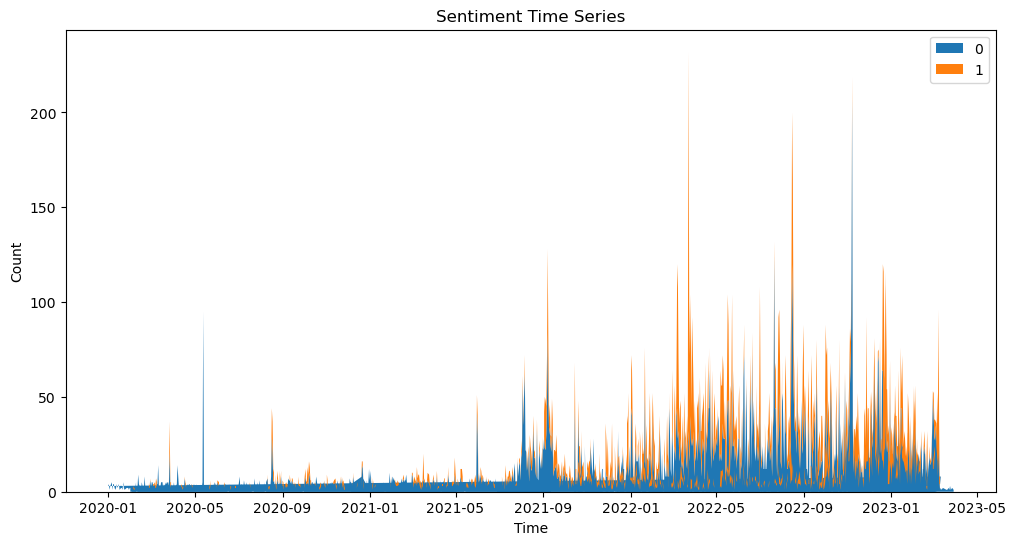

In [28]:
# time series
sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Sentiment Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Create a document-term matrix

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer without specifying stopwords
vectorizer = CountVectorizer()

# Fit the vectorizer on your text data
matrix = vectorizer.fit_transform(df['text'])

# Convert the matrix to an array and print it
print(matrix.toarray())

# Get the feature names and print them
feature_names = vectorizer.get_feature_names_out()
# print(feature_names)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##### Train the LDA model

In [30]:
from sklearn.decomposition import LatentDirichletAllocation
# Define the number of topics
num_topics = 5

# Create an instance of LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the LDA model on the document-term matrix
lda_model.fit(matrix)

# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


Topic #1: taliban, people, national, afghanistan, province, district, god, may, nangarhar, security
Topic #2: women, afghanistan, afghan, taliban, people, peace, one, men, country, today
Topic #3: taliban, afghanistan, kabul, us, people, afghan, killed, women, attack, one
Topic #4: girls, women, afghanistan, taliban, education, school, afghan, schools, right, country
Topic #5: rights, taliban, women, human, international, afghanistan, afghan, womens, community, people


##### Extract and interpret the topics

In [31]:
topic_word_distributions = lda_model.components_
# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(topic_word_distributions):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: taliban, people, national, afghanistan, province, district, god, may, nangarhar, security
Topic #2: women, afghanistan, afghan, taliban, people, peace, one, men, country, today
Topic #3: taliban, afghanistan, kabul, us, people, afghan, killed, women, attack, one
Topic #4: girls, women, afghanistan, taliban, education, school, afghan, schools, right, country
Topic #5: rights, taliban, women, human, international, afghanistan, afghan, womens, community, people


##### Assign topics to documents

In [32]:
# Transform the document-term matrix to topic distribution
topic_distribution = lda_model.transform(matrix)
# Assign the most dominant topic to each document
document_topics = topic_distribution.argmax(axis=1)
# Add the assigned topics to the DataFrame or a new column
df['topic'] = document_topics


##### Get the top words for each topic


In [33]:
# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the indices of the top words for each topic
top_word_indices = lda_model.components_.argsort(axis=1)[:, ::-1]

# Define the number of top words to display
num_top_words = 5

# Print the top words for each topic
for topic_id, word_indices in enumerate(top_word_indices):
    top_words = [feature_names[word_index] for word_index in word_indices[:num_top_words]]
    print(f"Topic {topic_id}: {top_words}")


Topic 0: ['taliban', 'people', 'national', 'afghanistan', 'province']
Topic 1: ['women', 'afghanistan', 'afghan', 'taliban', 'people']
Topic 2: ['taliban', 'afghanistan', 'kabul', 'us', 'people']
Topic 3: ['girls', 'women', 'afghanistan', 'taliban', 'education']
Topic 4: ['rights', 'taliban', 'women', 'human', 'international']


##### Analyzing topic distribution

In [34]:
# Calculate topic frequencies
topic_frequencies = df['topic'].value_counts()

print(topic_frequencies)


topic
0    6387
1    6324
4    6007
2    5707
3    5249
Name: count, dtype: int64


##### Visualize topic distribution

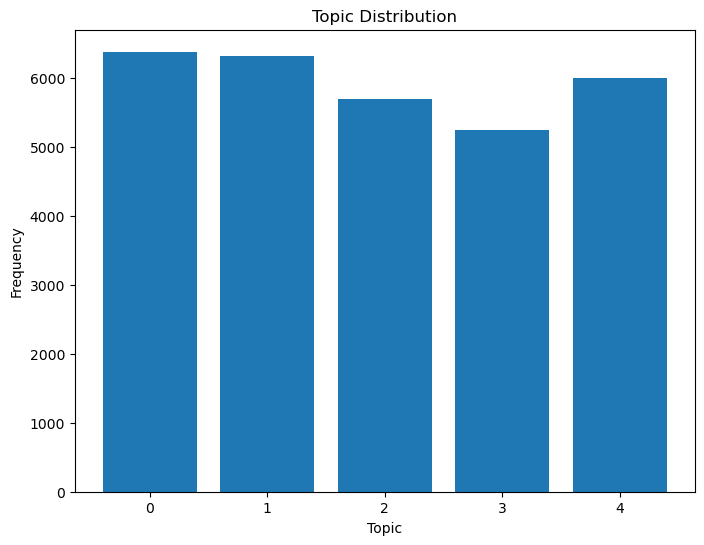

In [35]:
import matplotlib.pyplot as plt

# Calculate topic frequencies
topic_counts = df['topic'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(topic_counts.index, topic_counts.values)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Topic Distribution')
plt.show()


##### Identify dominant topics:

In [36]:
# Iterate over each document
for index, row in df.iterrows():
    # Get the dominant topic for the document
    dominant_topic = row['topic']
    # Print the document text and its dominant topic
    print(f"Document: {row['topic']}")
    print(f"Dominant Topic: {dominant_topic}")


Document: 3
Dominant Topic: 3
Document: 1
Dominant Topic: 1
Document: 2
Dominant Topic: 2
Document: 0
Dominant Topic: 0
Document: 4
Dominant Topic: 4
Document: 0
Dominant Topic: 0
Document: 1
Dominant Topic: 1
Document: 0
Dominant Topic: 0
Document: 0
Dominant Topic: 0
Document: 0
Dominant Topic: 0
Document: 0
Dominant Topic: 0
Document: 3
Dominant Topic: 3
Document: 2
Dominant Topic: 2
Document: 1
Dominant Topic: 1
Document: 0
Dominant Topic: 0
Document: 1
Dominant Topic: 1
Document: 0
Dominant Topic: 0
Document: 3
Dominant Topic: 3
Document: 1
Dominant Topic: 1
Document: 0
Dominant Topic: 0
Document: 4
Dominant Topic: 4
Document: 4
Dominant Topic: 4
Document: 3
Dominant Topic: 3
Document: 0
Dominant Topic: 0
Document: 1
Dominant Topic: 1
Document: 1
Dominant Topic: 1
Document: 1
Dominant Topic: 1
Document: 1
Dominant Topic: 1
Document: 2
Dominant Topic: 2
Document: 2
Dominant Topic: 2
Document: 2
Dominant Topic: 2
Document: 0
Dominant Topic: 0
Document: 0
Dominant Topic: 0
Document: 

##### Sentiment Analysis: Analyze the sentiment associated with each dominant topic

In [37]:
# Assign sentiment labels based on sentiment scores
df['sentiment_label'] = df['sentiment_score'].apply(lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral')

# Calculate average sentiment score for each dominant topic
average_sentiment = df.groupby('topic')['sentiment_score'].mean()

# Calculate percentage of positive, negative, and neutral sentiment for each dominant topic
sentiment_counts = df.groupby(['topic', 'sentiment_label']).size().unstack(fill_value=0)
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Print the results
print("Average Sentiment Score by Topic:")
print(average_sentiment)
print("\nPercentage of Sentiment Labels by Topic:")
print(sentiment_percentages)


Average Sentiment Score by Topic:
topic
0    0.050851
1    0.106719
2    0.016177
3    0.046240
4    0.009872
Name: sentiment_score, dtype: float64

Percentage of Sentiment Labels by Topic:
sentiment_label   Negative    Neutral   Positive
topic                                           
0                25.207453  37.795522  36.997025
1                21.252372  30.234029  48.513599
2                29.963203  33.730506  36.306291
3                22.118499  36.540293  41.341208
4                27.068420  39.920093  33.011487


##### Perform topic keywords analysis

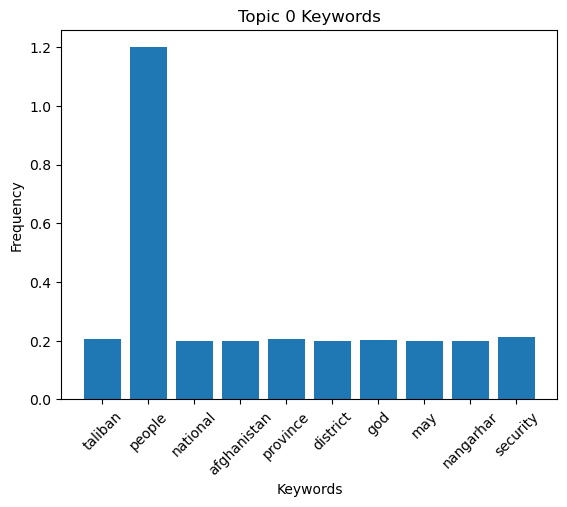

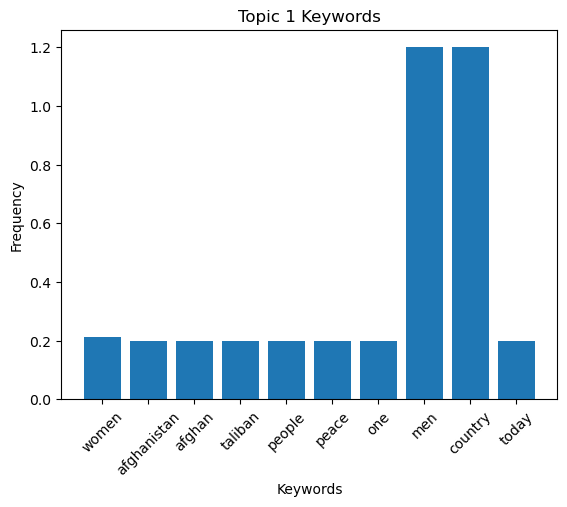

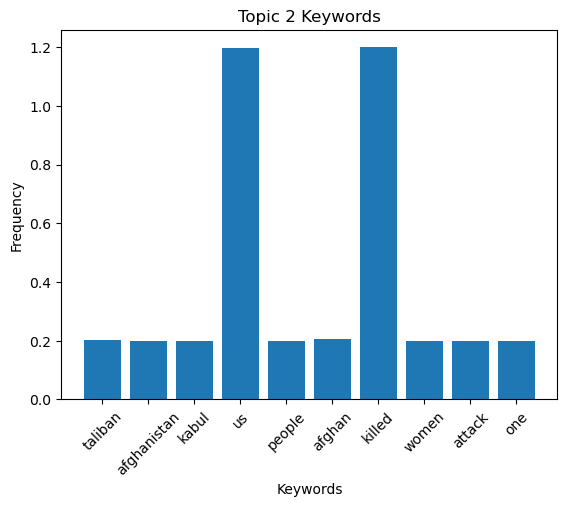

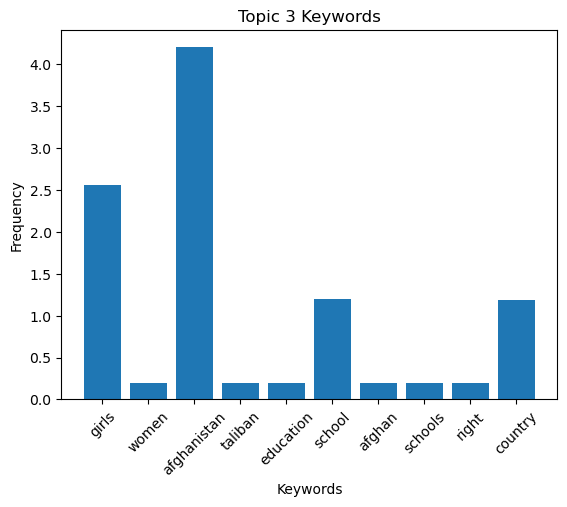

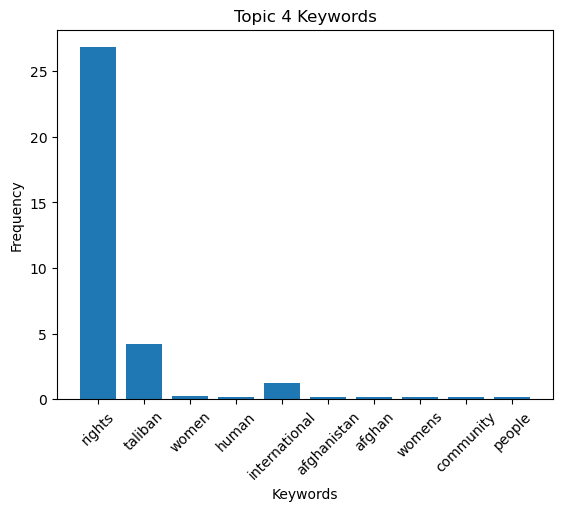

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

num_topics = lda_model.n_components

num_keywords = 10

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Iterate over each topic
for topic_idx in range(num_topics):
    # Get the top keywords for the topic based on their weights
    topic_keywords = lda_model.components_[topic_idx]
    top_keywords_indices = topic_keywords.argsort()[:-num_keywords - 1:-1]
    top_keywords = [feature_names[i] for i in top_keywords_indices]
    
    # Create a dictionary of keyword frequencies
    keyword_freq = {keyword: topic_keywords[i] for i, keyword in enumerate(top_keywords)}
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_freq)
    
    # Create a bar chart
    plt.bar(keyword_freq.keys(), keyword_freq.values())
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title(f'Topic {topic_idx} Keywords')
    plt.xticks(rotation=45)
    plt.show()


In [39]:
df.head()

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score,sex,women education,topic,sentiment_label
0,punishment torture someone punishment means criminal must pay price pleasure enjoying power law,DrSitez,2023-02-07 00:00:00,male,tajik,0,positive,0.050000,1.0,0,3,Positive
1,may right thinking wrong mind sick matter much right thing result disaster,DrSitez,2023-02-01 00:00:00,male,tajik,0,negative,-0.160714,1.0,0,1,Negative
2,situation taliban inflicted real hell women entire afghans unamas deputy call,DrSitez,2022-12-26 00:00:00,male,tajik,1,positive,0.100000,1.0,0,2,Positive
3,ghani karzai abdullah leaders regime fugitives right symbolically condemn talibans actions girls name people,DrSitez,2022-12-24 00:00:00,male,tajik,1,positive,0.285714,1.0,0,0,Positive
4,society researchers analysts journalists intellectuals academics lazy criminals often gain power ch,DrSitez,2022-11-23 00:00:00,male,tajik,0,negative,-0.250000,1.0,0,4,Negative


##### Gender Positive and Negative tweets

In [40]:

df_negative = df[df['sentiment'] == 'negative']
# Display counts of 'positive' and 'negative' values in 'sentiment' column for women
women_negative_count = df_negative[df_negative['gender'] == 'female'].shape[0]
women_positive_count = df[(df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
# Display counts of 'positive' and 'negative' values in 'sentiment' column for men
men_negative_count = df_negative[df_negative['gender'] == 'male'].shape[0]
men_positive_count = df[(df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
# Display the counts
print("Women Negative Count:", women_negative_count)
print("Women Positive Count:", women_positive_count)
print("Men Negative Count:", men_negative_count)
print("Men Positive Count:", men_positive_count)


Women Negative Count: 6714
Women Positive Count: 10301
Men Negative Count: 737
Men Positive Count: 1355


##### Check gender positive and negative tweets

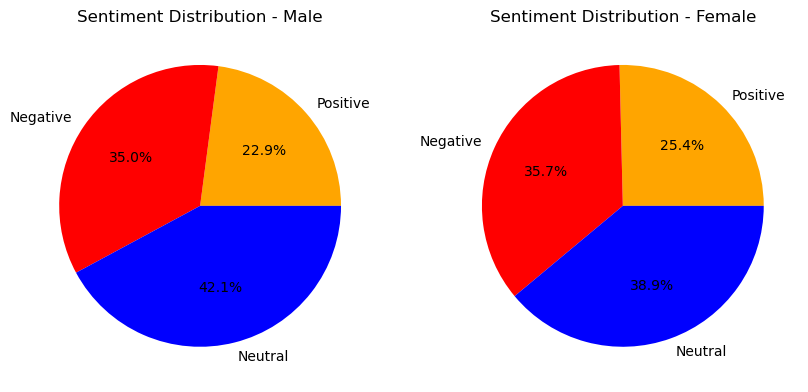

In [41]:
# pie chart
gender_categories = ['Male', 'Female']
sentiment_categories = ['Positive', 'Negative', 'Neutral']
sentiment_counts = df.groupby(['gender', 'sentiment']).size().unstack()
# Extract sentiment counts for each gender
male_counts = sentiment_counts.loc['male']
female_counts = sentiment_counts.loc['female']
# Define colors for each sentiment category
colors = ['orange', 'red', 'blue']
# Create subplots for male and female pie charts
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Create pie chart for male sentiment distribution
axes[0].pie(male_counts, labels=sentiment_categories, colors=colors, autopct='%1.1f%%')
axes[0].set_title('Sentiment Distribution - Male')
# Create pie chart for female sentiment distribution
axes[1].pie(female_counts, labels=sentiment_categories, colors=colors, autopct='%1.1f%%')
axes[1].set_title('Sentiment Distribution - Female')
# Show the charts
plt.show()

##### Visualize time series data

In [42]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

In [43]:
df[['created_at']].sample(5)

,created_at
23117,2022-03-07
418,2023-01-19
20952,2022-09-26
22915,2022-04-03
18699,2022-04-07


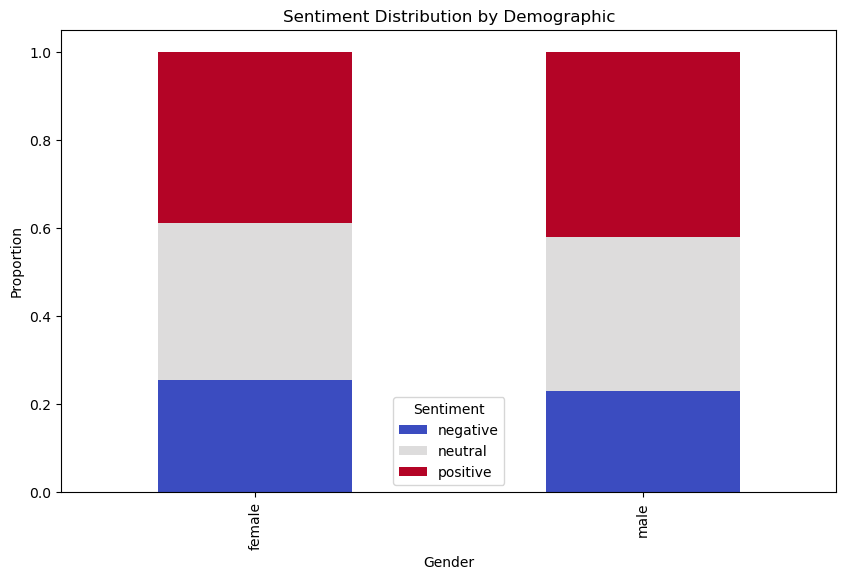

In [44]:
sentiment_counts = df.groupby(['gender', 'sentiment']).size().unstack()
# Calculate the total count for each demographic variable
total_counts = sentiment_counts.sum(axis=1)

# Calculate the proportion of each sentiment category for each demographic variable
sentiment_proportions = sentiment_counts.div(total_counts, axis=0)

# Create a stacked bar chart
sentiment_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.title('Sentiment Distribution by Demographic')

# Add legend
plt.legend(title='Sentiment')

# Show the stacked bar chart
plt.show()


for the 'gender' category 'female', the proportions are:

1- Negative: 0.171005

2- Neutral: 0.37137

3- Positive: 0.457626

Similarly, for the 'gender' category 'male', the proportions are:

1- Negative: 0.188787

2- Neutral: 0.37302

3- Positive: 0.438193

In [45]:
# sentiment proportions
print(sentiment_proportions)

sentiment  negative   neutral  positive
gender                                 
female     0.253761  0.356905  0.389334
male       0.229167  0.349502  0.421331


##### Word cloud:

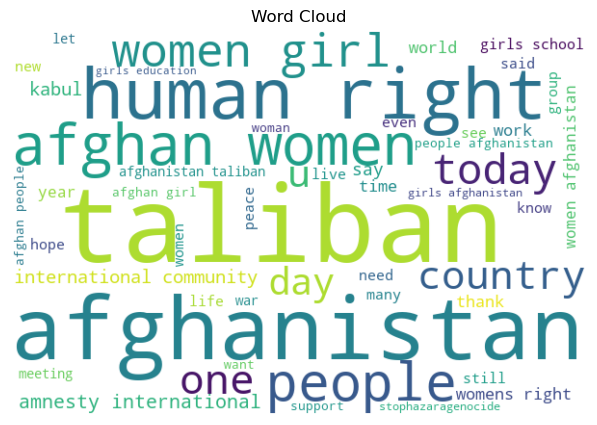

In [46]:

from wordcloud import WordCloud
text_data = " ".join(df['text'].tolist())
wordcloud = WordCloud(width=600, height=400, max_words=50, background_color='white').generate(text_data)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


In [47]:

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned tweet text data into a TF-IDF representation
X = vectorizer.fit_transform(df)

# X is now a sparse matrix where each row represents a tweet as a vector of TF-IDF values


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer

# Assuming you have a list of tweets in x and their corresponding labels in y
x = df['text']
y = df['label']

# Convert text data into numerical features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(x)

# Split the labeled data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of LogisticRegression
clf = LogisticRegression()

# Fit the logistic regression model to the training set data and labels
clf.fit(X_train, y_train)

# Predict labels for the test set data using the trained logistic regression model
y_pred = clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))


Accuracy: 1.00
Precision: 1.00
Recall: 0.99
F1-score: 0.99


In [49]:
import re
df['text'] = df['text'].str.strip()
df['text'] = df['text'].astype(str)
def doublespace(text):
    return re.sub(r'\s+', ' ', text).strip()
df['text'] = df['text'].apply(doublespace)

In [50]:
df[['text']].sample(10)

,text
17888,honoring afghan girls robotics team first global competition afghan girls robotics team two medals
15426,badakhshan pm yesterday operation national resistance front forces end hospital professor burhanuddin rabbani old city faizabad badakhshan province taliban fighters seriously injured vehicle maulvi rashad head security called taliban terrorist group badakhshan magnetic mine
14747,studied lesson secretly mosques unemployed houses malestan district reached stage malestan fell taliban recent days worried today generation lest deprived education darkness group notothetaliban
2086,amnesty international talibans reference sharia afghanism old trick designed deny womens rights
1743,unconditional hate taliban toward women
14270,complete list
6354,comprehensive thread daily violence afghanistan international indifference
19473,sometimes feels ashamed masculinity men made afghan women almost half century caused trouble destroyed rights women part war misfortune victims depriving basic rights like education working
17014,call november twitter storm pine stop millennial genocide forget stophazaragenocide
28068,finally jihad failed god turned away lied led nation famine


In [51]:
df.dropna(subset=['text'], inplace=True) #remove nan value
df.drop_duplicates(subset=['text'], inplace=True) #remove nan duplicate value
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=1, how='all')

In [52]:
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
# Apply to the DF series
df['text'] = df['text'].apply(remove_punctuations)


##### Get every year just once, like unique year

In [53]:
df.shape

(16389, 12)

In [54]:
df.head()

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score,sex,women education,topic,sentiment_label
0,punishment torture someone punishment means criminal must pay price pleasure enjoying power law,DrSitez,2023-02-07,male,tajik,0,positive,0.050000,1.0,0,3,Positive
1,may right thinking wrong mind sick matter much right thing result disaster,DrSitez,2023-02-01,male,tajik,0,negative,-0.160714,1.0,0,1,Negative
2,situation taliban inflicted real hell women entire afghans unamas deputy call,DrSitez,2022-12-26,male,tajik,1,positive,0.100000,1.0,0,2,Positive
3,ghani karzai abdullah leaders regime fugitives right symbolically condemn talibans actions girls name people,DrSitez,2022-12-24,male,tajik,1,positive,0.285714,1.0,0,0,Positive
4,society researchers analysts journalists intellectuals academics lazy criminals often gain power ch,DrSitez,2022-11-23,male,tajik,0,negative,-0.250000,1.0,0,4,Negative


In [55]:
# df.to_excel('../data_processed/indivitual/es_afghan_wgh_tajik_activists.xlsx', index=False)